In [2]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import MDAnalysis as mda
import numpy as np 
import warnings 
import os
warnings.filterwarnings('ignore')


/home/yiechang/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
##make a lil colour palette 
pal = sns.hls_palette(n_colors=12, h=0.314159265359, l=0.6, s=0.75, as_cmap=False)
palhex = pal.as_hex()

# lipid dictionary for lipid species and colour assignment 
lipids = {
    "LPC" : {
        "species" : ["PPC", "OPC", "IPC", "APC", "UPC"],
        "color" : palhex[0],
    },
    "GM" : {
        "species" : ["DPG1", "DXG1", "PNG1", "XNG1", "DPG3", "DXG3", "PNG3", "XNG3"],
        "color" : palhex[7],
    },
    "CER" : {
        "species" : ["DPCE", "DXCE", "PNCE", "XNCE"],
        "color" : palhex[4],
    },
    "PIP" : {
        "species" : ["POP1","POP2","POP3"],
        "color" : palhex[5],
    },
    "PA" : {
        "species" : ["POPA", "PIPA", "PAPA", "PUPA"],
        "color" : palhex[9],
    },
    "PI" : {
        "species" : ["POPI", "PIPI", "PAPI", "PUPI"],
        "color" : palhex[6],
    },
    "PS" : {
        "species" : ["POPS", "PIPS", "PQPS", "PAPS", "DAPS", "PUPS", "DUPS"],
        "color" : palhex[1],
    },
    "SM" : {
        "species" : ["DPSM", "DBSM", "DXSM", "POSM", "PGSM", "PNSM", "BNSM", "XNSM"],
        "color" : palhex[3],
    },
    "PE" : {
        "species" : ["POPE", "DOPE", "PIPE", "PQPE", "PAPE", "DAPE", "PUPE", "DUPE"],
        "color" : palhex[2],
    },
    "PC" : {
        "species" : ["POPC", "DOPC", "PIPC", "PEPC", "PAPC", "DAPC", "PUPC"],
        "color" : palhex[11],
    },
    "CL" : {
        "species" : ["CHOL"],
        "color" : palhex[10],
    },
    "DG" : {
        "species" : ["PODG", "PIDG", "PADG", "PUDG"],
        "color" : palhex[8],
    }
}

#3 letter to 1 letter amino acid code dictionary 
amino = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K','ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


The code below analyses the contact frequency of different lipid types to residues on Nav1.4 and produces the figure panels seen in Fig. 1(D) and Fig. S3

Index(['K1330', 'K1333', 'R1463', 'G1464', 'K1466', 'R1469'], dtype='object', name='index')


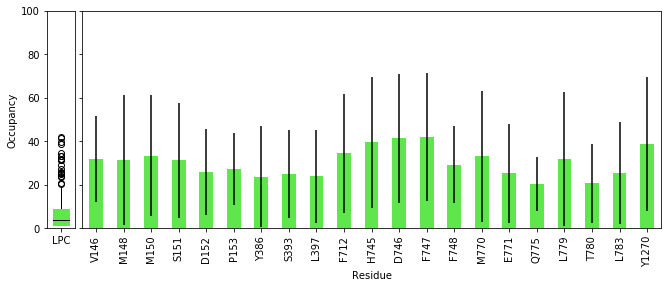

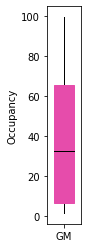

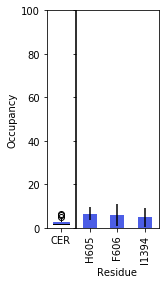

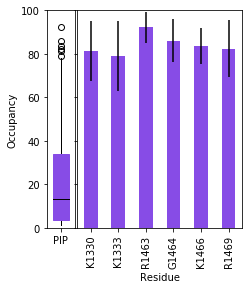

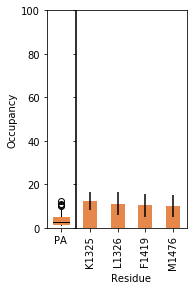

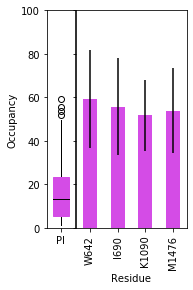

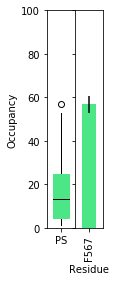

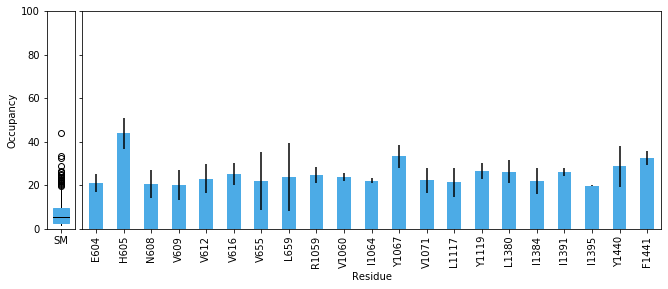

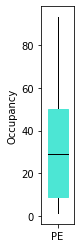

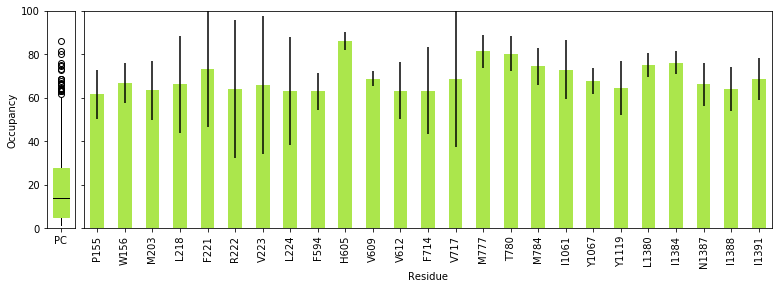

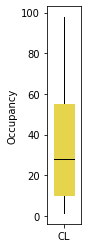

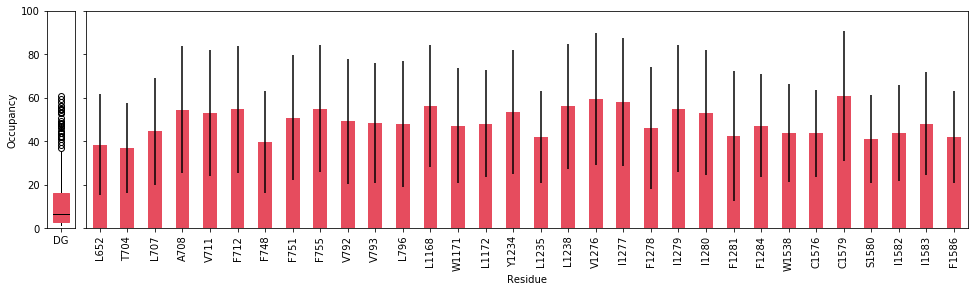

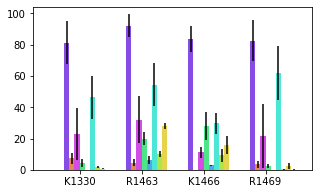

In [3]:
##First, run contact.sh, which implements a tcl script to calculate contact occupancy of each lipid headgroup type around each residue (defined as the proportion of simulation time for which 
##a lipid belonging to this group is within 7 Angstroms of a residue) and store this information in the beta column of a PDB.   

#os.system('cd contacts; bash contact.sh; mkdir contact-pdb')

##make a dataframe for conversion between gro numbering and actual amino acid numbering for residues 
def read_renumtxt(filepath):
    """Read the renumbering file generated by amber tleap; return pandas df"""
    df = pd.read_csv(filepath, delim_whitespace=True, names=["RES", "og_num", "RES1", "new_num"])
    df = df.astype({"og_num": int, "new_num": int})   
    return df

dfrenum = read_renumtxt("contacts/6agf_renum.txt")
dfrenum = dfrenum.set_index('new_num')
dfrenum["index"]=dfrenum['RES'].map(amino)+dfrenum['og_num'].astype(str)

##loop through PDBs produced by the contact frequency script, read the beta column in as a column of the dataframe 
reps= ['1','2','3']
lip= list(lipids.keys())

m=pd.DataFrame(index=dfrenum['index'])

for i in reps:
    for l in lip:
            u=mda.Universe('contacts/rep'+str(i)+"/"+l+'.pdb')
            m[i+"-"+l]=list(u.atoms.tempfactors)

##average contact occupancies across replicates, calculate SEM, make an average PDB 
u=mda.Universe('contacts/rep1/LPC.pdb')
avg=pd.DataFrame(index=m.index)
err=pd.DataFrame(index=m.index)

for i in lip:
    avg[i]=m.iloc[:,lip.index(i)::12].mean(axis=1)
    err[i]=m.iloc[:,lip.index(i)::12].sem(axis=1)
    u.atoms.tempfactors=0
    u.atoms.tempfactors=avg[i]
    u.atoms.write("contacts/contact-pdb/"+i+".pdb")

##function to find outlying contact occupancies 
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

## for each lipid headgroup type, if the contact frequency is more than 1 (it's in contact with the membrane) plot the distribution of contact occupancies
## frequencies and produce a bar chart with the contact occupancies of any outlying values. 
for i in lip:
    filt=avg[avg[i]>1][[i]]
    out=find_outliers_IQR(filt).dropna()
    props = dict(boxes=lipids[i]['color'], whiskers="black", medians="black", caps="white")
    if out.empty==False:
        fig, axes = plt.subplots(ncols=2, figsize=(0.5*(len(out)+1), 4), gridspec_kw={'width_ratios':[1, len(out)], 'wspace': 0.025}, sharey=True)
        filt.plot.box(ax=axes[0], grid=False, color=props, patch_artist=True, ylabel='Occupancy', widths=0.6)
        avg.loc[out.index][i].plot.bar(yerr=err, ylabel='Occupancy', color=lipids[i]['color'], ax=axes[1], ylim=(0,100), xlabel='Residue')
        plt.savefig('contacts/FigS3-'+i+'.png', dpi=600, bbox_inches="tight")
    else: 
        filt.plot.box(grid=False, color=props, patch_artist=True, ylabel='Occupancy', widths=0.6, figsize=(0.6,4))
        plt.savefig('contacts/FigS3-'+i+'.png', dpi=600, bbox_inches="tight")

##as above, but plot occupancy of all lipid headgroups for residues identified to comprise the PIP binding site 
for i in ['PIP']:
    filt=avg[avg[i]>1][[i]]
    out=find_outliers_IQR(filt).dropna()
    print(out.index)

pip=['K1330', 'R1463', 'K1466', 'R1469']
avg.loc[pip].plot.bar(yerr=err, color=[lipids[x]['color'] for x in lipids.keys()], figsize=(5,3), width=1, rot=0, legend=False, xlabel='')
plt.savefig('contacts/Fig1D.png', dpi=600, bbox_inches="tight")

The code below calculates the lipid depletion/enrichment (DE) index for the different lipid types around Nav1.4 and produces the plot shown in Fig. 2(B)

In [21]:
#call a script to count the number of a specific lipid type within 20 A of the protein over time 
os.system('cd lipidDE/; bash lipidDE.sh')

#concatenate within replicates, write a csv
for rep in [1,2,3]:
    concatdf = pd.concat((pd.read_csv("lipidDE/rep"+str(rep)+"_"+f+'.csv', sep=' ', index_col=0) for f in lipids), axis=1)
    concatdf.to_csv('lipidDE/DE_rep'+str(rep)+'.csv', sep=' ')

#lil clean 
os.system('rm lipidDE/rep*csv')

def flatten(l):
    return [item for sublist in l for item in sublist]

all=flatten([lipids[x]["species"] for x in lipids.keys()])
lipids['all']={'species': all, "color":'black'}


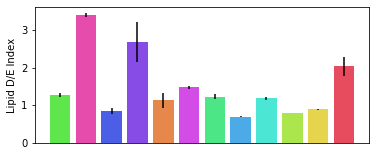

In [22]:
#aggregate data across dataframes 
agg=pd.DataFrame()
for rep in [1,2,3]:
    u = mda.Universe('traj/labelled.gro')
    df=pd.read_csv('lipidDE/DE_rep'+str(rep)+'.csv', sep=' ', index_col=0)
    df.columns=['LPC', 'GM', 'CER', 'PIP', 'PA', 'PI', 'PS', 'SM', 'PE', 'PC', 'CL', 'DG', 'all']
    for j in lipids:
        #calculate lipid concentration 
        lipids[j]["conc"]=len(u.select_atoms('resname '+ " ".join(lipids[j]['species'])).residues)/len(u.select_atoms('not name BB SC1 SC2 SC3 SC4').residues)
    for k in lipids.keys():
        #calculate lipid concentration within cutoff 
        df[k]=df[k]/lipids[k]["conc"]
        #calculate lipid concentration within cutoff as a proportion of total lipids within cutoff
        df[k]=df[k]/df["all"]
    agg[rep]=df.mean()

agg=agg.drop('all')
plt.figure(figsize=(6,2.5))
plt.bar(x=agg.index, height=agg.mean(axis=1), yerr=agg.sem(axis=1), color=[lipids[x]['color'] for x in lipids.keys()])
plt.ylabel('Lipid D/E Index')
plt.xticks([])
plt.savefig('Fig2B.svg', dpi=300)

The code below generates the lipid z-density maps seen in Fig S1-2 

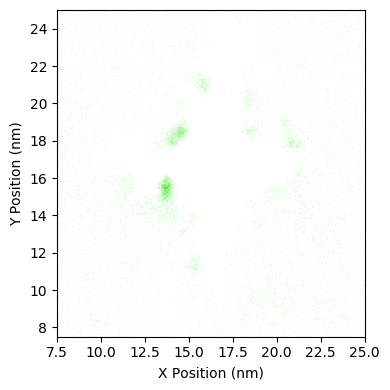

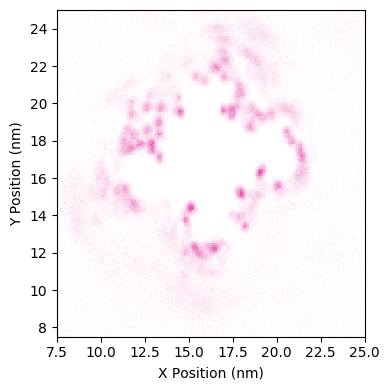

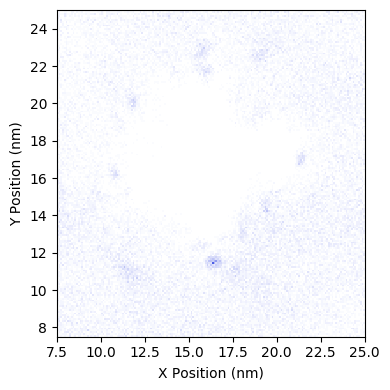

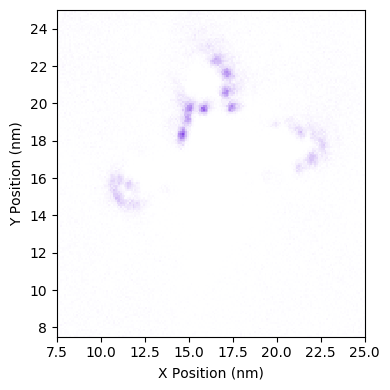

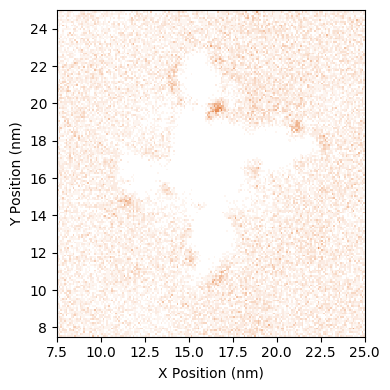

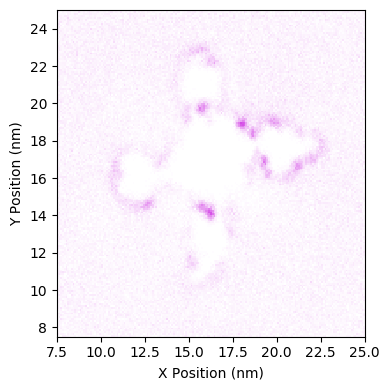

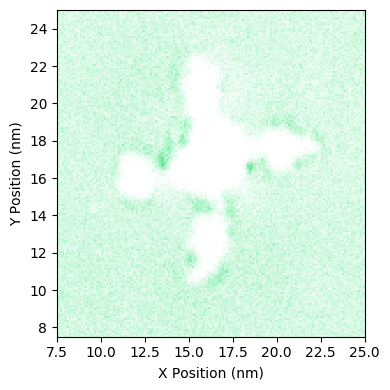

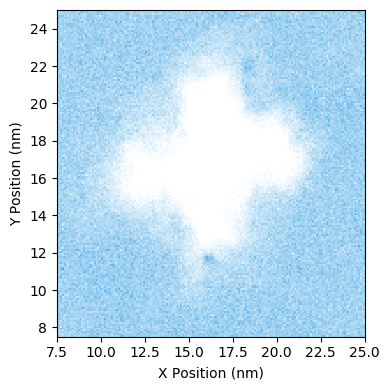

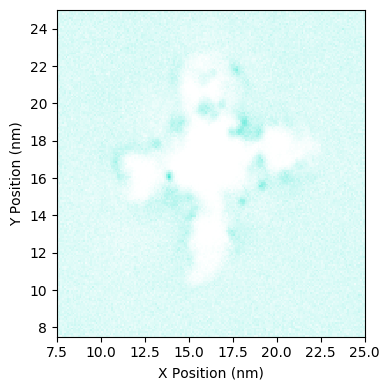

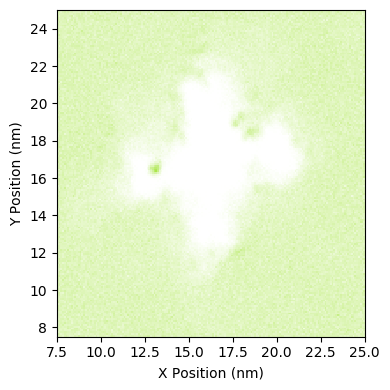

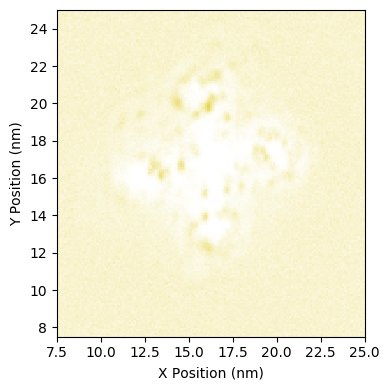

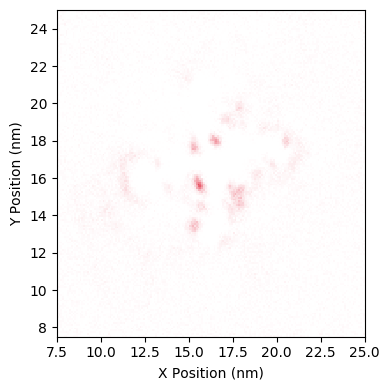

In [8]:
##make an index file and run gmx densmap on a trajectory containing the last 8 us of all three replicates 
#os.system('cd dm; bash dm_hg.sh')

#read in the .dat file produced by gmx densmap and make plot as a color map 
for i in lipids.keys():
    df= pd.read_csv("dm/dm_"+i+".dat", sep='\t', index_col=0).dropna(axis=1)
    ncmap=mpl.colors.LinearSegmentedColormap.from_list("", ["white", lipids[i]["color"]])
    plt.figure(dpi=100, figsize=(4,4))
    plt.pcolormesh(df.index, df.index, df,cmap=ncmap, shading='nearest')
    plt.xlabel('X Position (nm)')
    plt.ylabel('Y Position (nm)')
    plt.xlim(7.5,25)
    plt.ylim(7.5,25)
  #  plt.title(i+" Density Map")
    plt.tight_layout()
    plt.savefig('dm/'+i, dpi=100)

The code below calls a VMD script which generates the images of lipid occupancy mapped onto the Nav1.4 structure. 

In [5]:
os.system('cd contacts/contact-pdb; bash snap.sh;')

The code below tiles the lipid z-density maps and VMD generated images of lipid occupancy mapped on to the Nav1.4 structure seen in Fig S1-2 

In [13]:
#a function to tile images 
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

#tile the z-density map and 4 views for each lipid headgroup type 
for i in lipids.keys():
    im_list=[Image.open("dm/"+i+".png").resize((1150,1016))]
    for v in ['3', '4', '1', '2']:
        im_list.append(Image.open("contacts/contact-pdb/tga/"+i+"-"+v+".tga"))
    im = image_grid(im_list, rows=1, cols=5)
    draw = ImageDraw.Draw(im)
    draw.text((5500,50), i, fill=lipids[i]["color"], font=ImageFont.truetype('Ubuntu-B.ttf', 120))
    im.save('contacts/contact-pdb/'+i+'_t.png')

#tile the tiled images into FigS1 
tile=[]
for i in list(lipids.keys())[:6]:
    tile.append(Image.open('contacts/contact-pdb/'+i+'_t.png'))
im=image_grid(tile, cols=1, rows=6)
im.save('contacts/contact-pdb/SFig1.png')

#same for FigS2
tile=[]
for i in list(lipids.keys())[6:]:
    tile.append(Image.open('contacts/contact-pdb/'+i+'_t.png'))
im=image_grid(tile, cols=1, rows=6)
im.save('contacts/contact-pdb/SFig2.png')

os.system('rm contacts/contact-pdb/*t.png')

0